In [2]:
import pandas as pd
import numpy as np
from storeSalesUtils.dataloading import DATA_FOLDER, load_test
import os

In [3]:
file_xgb = os.path.join(DATA_FOLDER, 'predictions/XGBoostBase_medianFilter.csv')
xgb_pred = pd.read_csv(file_xgb)
xgb_pred.columns = ['id', 'xgb_sales']

file_prophet = os.path.join(DATA_FOLDER, 'predictions/prophetBase_medianFilter.csv')
prophet_pred = pd.read_csv(file_prophet)
prophet_pred.columns = ['id', 'prophet_sales']

file_prophet = os.path.join(DATA_FOLDER, 'predictions/baseline_14D.csv')
base_pred = pd.read_csv(file_prophet)
base_pred.columns = ['id', 'baseline_sales']

file_prophet2 = os.path.join(DATA_FOLDER, 'predictions/prophet_dataPooling_weeklySeasonal.csv')
prophet_pred2 = pd.read_csv(file_prophet2)
prophet_pred2.columns = ['id', 'prophet_sales2']

prediction_df = pd.merge(xgb_pred, prophet_pred, on='id')
prediction_df = pd.merge(prediction_df, base_pred, on='id')
prediction_df = pd.merge(prediction_df, prophet_pred2, on='id')
print(prediction_df.shape)
prediction_df.head()

(28512, 5)


,id,xgb_sales,prophet_sales,baseline_sales,prophet_sales2
0,3000888,1.150418,3.522082,7.0,5.0
1,3002670,1.150418,3.051321,4.0,5.0
2,3004452,0.744947,4.300172,10.0,5.0
3,3006234,1.008611,4.551232,8.0,5.0
4,3008016,0.855981,1.755908,0.0,5.0


In [4]:
prediction_df.columns

Index(['id', 'xgb_sales', 'prophet_sales', 'baseline_sales', 'prophet_sales2'], dtype='object')

In [5]:
prediction_df['sales'] = prediction_df[['xgb_sales', 'prophet_sales',
                                        'baseline_sales', 'prophet_sales2']].mean(1)
prediction_df

,id,xgb_sales,prophet_sales,baseline_sales,prophet_sales2,sales
0,3000888,1.150418,3.522082,7.000000,5.0,4.168125
1,3002670,1.150418,3.051321,4.000000,5.0,3.300435
2,3004452,0.744947,4.300172,10.000000,5.0,5.011280
3,3006234,1.008611,4.551232,8.000000,5.0,4.639961
4,3008016,0.855981,1.755908,0.000000,5.0,1.902972
...,...,...,...,...,...,...
28507,3022139,2.307294,3.586525,4.000000,3.0,3.223455
28508,3023921,2.168031,3.198599,4.000000,3.0,3.091658
28509,3025703,2.936078,3.003442,3.000000,3.0,2.984880
28510,3027485,2.713150,3.387941,3.071429,3.0,3.043130


# Simple ensemble

In [6]:
# pred_file = os.path.join(DATA_FOLDER, 'predictions/XGB_Prophet_mean.csv')
# pred_file = os.path.join(DATA_FOLDER, 'predictions/XGB_Prophet_Baseline_mean.csv')
# pred_file = os.path.join(DATA_FOLDER, 'predictions/Prophet_Baseline_mean.csv')
pred_file = os.path.join(DATA_FOLDER, 'predictions/ensemble.csv')
formatted_pred = prediction_df[['id', 'sales']]
formatted_pred.to_csv(path_or_buf=pred_file, index=False)

In [7]:
formatted_pred

,id,sales
0,3000888,4.168125
1,3002670,3.300435
2,3004452,5.011280
3,3006234,4.639961
4,3008016,1.902972
...,...,...
28507,3022139,3.223455
28508,3023921,3.091658
28509,3025703,2.984880
28510,3027485,3.043130


It seems that a simple ensemble can lead us a long way:

Ensemble of the three models:

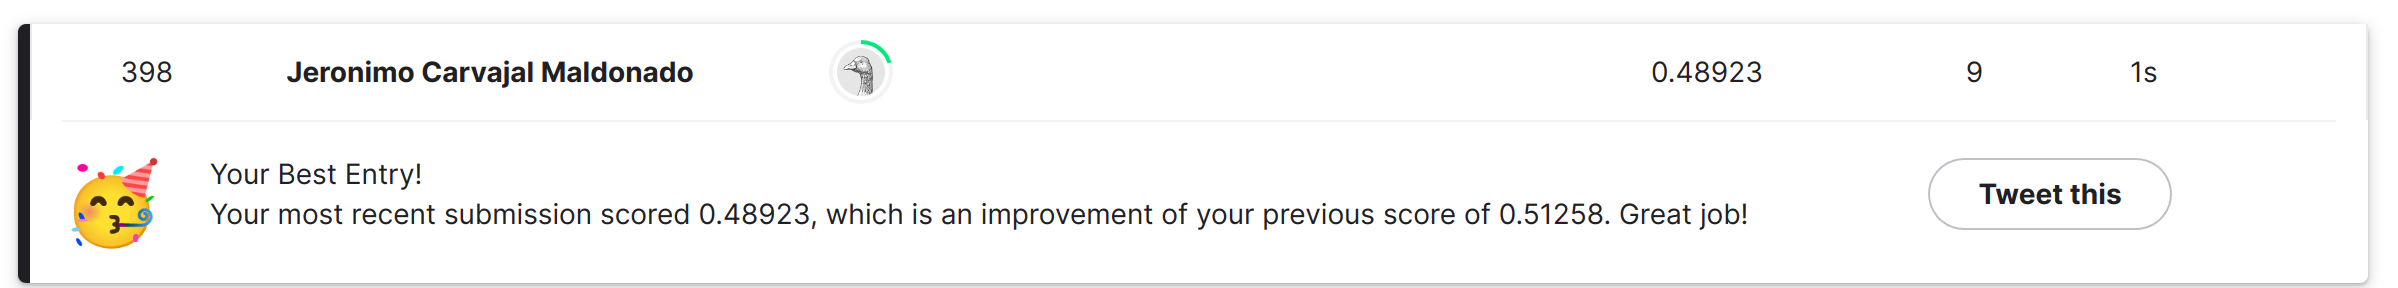

From the 866 participants at the moment of submission. That already on the best 50%

**NOTE** Only using Prophet and the baseline yielded worse results: 0.50906 test error.

# Replace entries with big error

In [23]:
test = load_test()

In [34]:
error_file_xgb = os.path.join(DATA_FOLDER, 'predictions/XGBoostBase_medianFilter_validationErrors.csv')
error_xgb = pd.read_csv(error_file_xgb)
error_xgb.columns = ['store_nbr', 'family', 'xgb_RMSLE_val']

error_file_prophet = os.path.join(DATA_FOLDER, 'predictions/prophetBase_medianFilter_validationErrors.csv')
error_prophet = pd.read_csv(error_file_prophet)
error_prophet.columns = ['store_nbr', 'family', 'prophet_RMSLE_val']

error_df = pd.merge(error_xgb, error_prophet, on=['store_nbr', 'family'])
error_df = pd.merge(test, error_df, on=['store_nbr', 'family'])
print(error_df.shape)
error_df.head()

(28512, 7)


,id,date,store_nbr,family,onpromotion,xgb_RMSLE_val,prophet_RMSLE_val
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0.736,0.46
1,3002670,2017-08-17,1,AUTOMOTIVE,0,0.736,0.46
2,3004452,2017-08-18,1,AUTOMOTIVE,0,0.736,0.46
3,3006234,2017-08-19,1,AUTOMOTIVE,0,0.736,0.46
4,3008016,2017-08-20,1,AUTOMOTIVE,0,0.736,0.46


In [37]:
ensemble_df = pd.merge(prediction_df, error_df, on='id')
ensemble_df['mean_sales'] = ensemble_df[['xgb_sales', 'prophet_sales']].mean(1)
ensemble_df['mean_RMSLE'] = ensemble_df[['xgb_RMSLE_val', 'prophet_RMSLE_val']].mean(1)

# one or the other rule
ensemble_df['sales'] = np.where(ensemble_df.xgb_RMSLE_val>ensemble_df.prophet_RMSLE_val, ensemble_df.prophet_sales, ensemble_df.xgb_sales)

# whenever we have strong agreement, choose the mean
ensemble_df['sales'] = np.where(ensemble_df.mean_RMSLE<0.5, ensemble_df.mean_sales, ensemble_df.sales)

ensemble_df

,id,xgb_sales,prophet_sales,sales,date,store_nbr,family,onpromotion,xgb_RMSLE_val,prophet_RMSLE_val,mean_sales,mean_RMSLE
0,3000888,1.150418,3.522082,3.522082,2017-08-16,1,AUTOMOTIVE,0,0.736,0.460,2.336250,0.598
1,3002670,1.150418,3.051321,3.051321,2017-08-17,1,AUTOMOTIVE,0,0.736,0.460,2.100869,0.598
2,3004452,0.744947,4.300172,4.300172,2017-08-18,1,AUTOMOTIVE,0,0.736,0.460,2.522559,0.598
3,3006234,1.008611,4.551232,4.551232,2017-08-19,1,AUTOMOTIVE,0,0.736,0.460,2.779922,0.598
4,3008016,0.855981,1.755908,1.755908,2017-08-20,1,AUTOMOTIVE,0,0.736,0.460,1.305945,0.598
...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3022139,2.307294,3.586525,2.307294,2017-08-27,54,SEAFOOD,0,0.882,1.012,2.946910,0.947
28508,3023921,2.168031,3.198599,2.168031,2017-08-28,54,SEAFOOD,0,0.882,1.012,2.683315,0.947
28509,3025703,2.936078,3.003442,2.936078,2017-08-29,54,SEAFOOD,0,0.882,1.012,2.969760,0.947
28510,3027485,2.713150,3.387941,2.713150,2017-08-30,54,SEAFOOD,0,0.882,1.012,3.050545,0.947


In [38]:
pred_file = os.path.join(DATA_FOLDER, 'predictions/XGB_Prophet_ensemble.csv')
formatted_pred = ensemble_df[['id', 'sales']]
formatted_pred.to_csv(path_or_buf=pred_file, index=False)

I think I am fine with this results. Not the best, but enough to feel prepared for a job interview =)

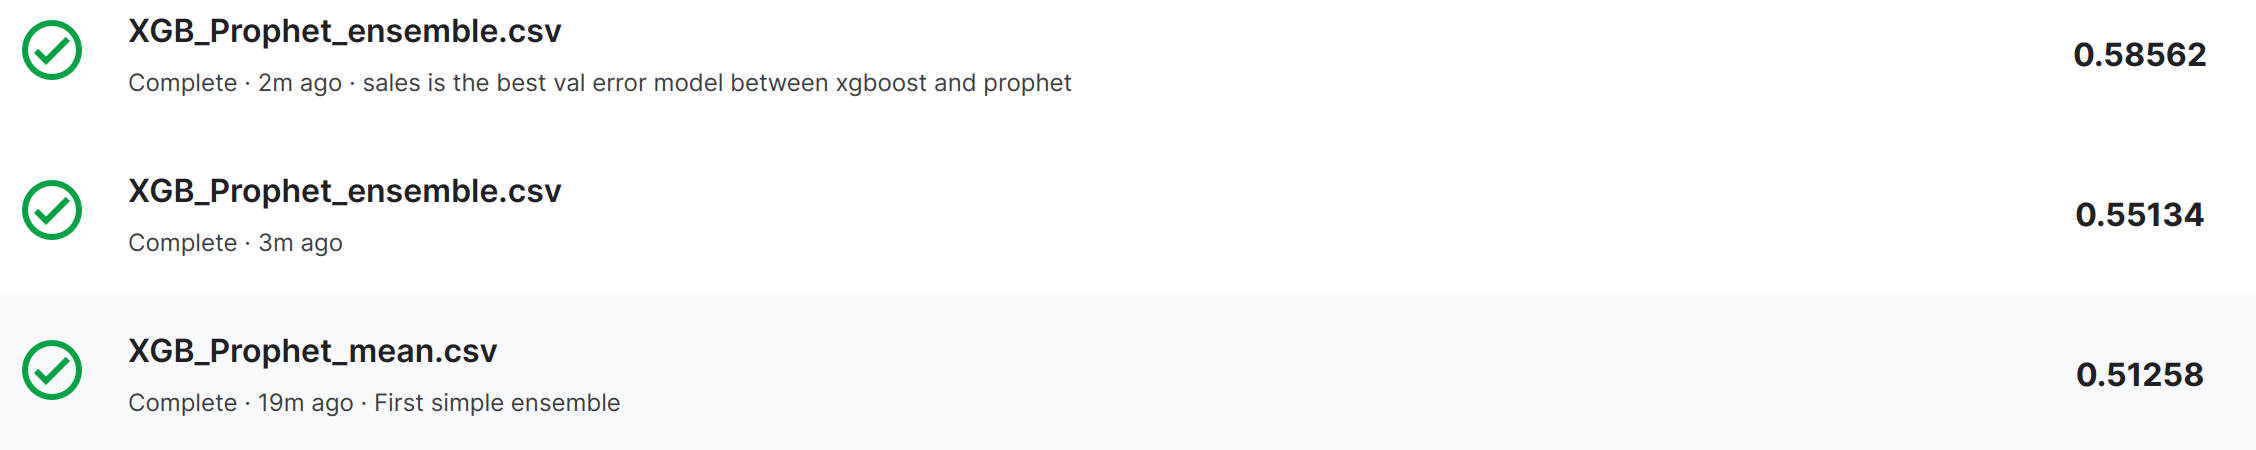